Code to test if a data can be classified into a particular bin of residential solar usage on the theory that regression models trained per bin might capture nuance of the subgroups more effectively

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, ensemble, svm

In [3]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

In [46]:
# https://www.kaggle.com/tunguz/deep-solar-dataset
df_all = pd.read_csv('deepsolar_tract.csv', encoding='latin-1')
df = df_all.dropna()
#df = df[df['solar_system_count_residential']>0]

In [47]:
for col in df_all.columns:
    try:
        pd.to_numeric(df_all[col])
    except:
        print(col)

county
state
electricity_price_transportation


In [48]:
df['median_income_per_area_residential'] = df['median_household_income'].div(df.land_area)
df['income_per_area_residential'] = df['average_household_income']*df['household_count'].div(df.land_area)
df['household_density'] = df['household_count'].div(df.land_area)
df['education_higher_ed_rate'] = (df['education_bachelor'] + df['education_doctoral'] + df['education_master'] + df['education_professional_school']).div(df.education_population)
df['age_retired']= df.population*df.age_65_74_rate + df.population*df.age_75_84_rate + df.population*df.age_more_than_85_rate 



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [107]:
target = 'solar_system_count_residential'#'total_panel_area'

# binned_var_omit = [col for col in df.columns if '_bin' in col]

omit = ['Unnamed: 0','fips','solar_system_count_nonresidential', 'total_panel_area', 'population_density_bin_equalwidth','population_density_bin_equaln','fips', 'county', 'electricity_price_transportation', 'total_panel_area_residential',
'total_panel_area_nonresidential',  'education_population','solar_panel_area_divided_by_area', 'solar_panel_area_per_capita',
        'tile_count','tile_count_residential', 'tile_count_nonresidential','number_of_solar_system_per_household', 'solar_system_count']

edu_omit = ['education_bachelor','education_college','education_doctoral','education_high_school_graduate','education_less_than_high_school','education_master','education_professional_school']
race_omit = ['race_asian','race_black_africa','race_indian_alaska','race_islander','race_other','race_two_more','race_white', 'race_indian_alaska_rate','race_two_more_rate']
heat_fuel_omit = ['heating_fuel_coal_coke','heating_fuel_electricity','heating_fuel_fuel_oil_kerosene','heating_fuel_gas','heating_fuel_housing_unit_count',
'heating_fuel_none','heating_fuel_other','heating_fuel_solar', 'heating_fuel_solar_rate']


edu_rate_omit = ['education_bachelor_rate','education_college_rate','education_doctoral_rate','education_high_school_graduate_rate','education_less_than_high_school_rate','education_master_rate','education_professional_school_rate']
race_rate_omit = ['race_asian_rate','race_black_africa_rate','race_indian_alaska_rate','race_islander_rate','race_other_rate','race_two_more_rate','race_white_rate','race_indian_alaska','race_two_more']
heat_fuel_rate_omit = ['heating_fuel_coal_coke_rate','heating_fuel_electricity_rate','heating_fuel_fuel_oil_kerosene_rate','heating_fuel_gas_rate','heating_fuel_housing_unit_count_rate',
'heating_fuel_none_rate','heating_fuel_other_rate','heating_fuel_solar_rate', 'heating_fuel_solar']

nonresidential = ['electricity_price_overall', 'electricity_consume_industrial', 'electricity_consume_total','electricity_price_industrial','electricity_price_commercial']

regardless_omit =['water_area', 'lon', 'heating_design_temperature']#['heating_fuel_fuel_oil_kerosene_rate','heating_fuel_fuel_oil_kerosene','race_indian_alaska_rate','race_islander_rate', 'race_indian_alaska','race_islander']

Testing a classifier followed by a regression model

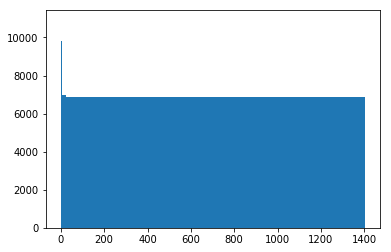

In [64]:
# Set up the training set and test set for splitting solar_system_count_residetial
# into n bins which will then be used to train a classifier

X = df.loc[:, ~(df.columns).isin(omit+regardless_omit+edu_omit+race_omit+heat_fuel_omit+ nonresidential)]#+binned_var_omit)]
Y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y)

n, ssc_bins_equln, patches = plt.hist(X_train.solar_system_count_residential, histedges_equalN(X_train.solar_system_count_residential, 6))
ssc_bins_equln[0] = -1
y_train_bins = pd.cut(X_train['solar_system_count_residential'],ssc_bins_equln, labels = [n for n in range(len(ssc_bins_equln)-1)])
y_test_bins  = pd.cut(X_test['solar_system_count_residential'], ssc_bins_equln, labels = [n for n in range(len(ssc_bins_equln)-1)])

X_train_bins = X_train.loc[:, ~(X_train.columns).isin([target])]
X_test_bins = X_test.loc[:, ~(X_test.columns).isin([target])]



In [110]:
# Set up the training set and test set for solar/no solar classification

X = df.loc[:, ~(df.columns).isin(omit+regardless_omit+edu_omit+race_omit+heat_fuel_omit+ nonresidential)]#+binned_var_omit)]
# X = df.loc[:, ~(df.columns).isin([target]+ omit+edu_rate_omit+race_rate_omit+heat_fuel_rate_omit+regardless_omit+ nonresidential)]
# features = ['median_household_income', 'education_bachelor_rate','population','race_white_rate', 'electricity_price_residential', 
#            'electricity_consume_residential', 'household_count','housing_unit_median_value','occupancy_owner_rate',
#            'mortgage_with_rate', 'age_35_44_rate', 'age_median','incentive_residential_state_level', 'voting_2016_dem_win']


# X = df[features]
Y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y)

y_train_bins = [1 if cts > 0 else 0 for cts in X_train['solar_system_count_residential']]
y_test_bins= [1 if cts > 0 else 0 for cts in X_test['solar_system_count_residential']]

X_train_bins = X_train.loc[:, ~(X_train.columns).isin([target]+['state'])]
X_test_bins = X_test.loc[:, ~(X_test.columns).isin([target]+ ['state'])]



In [ ]:
import time
start = time.time()
params = {'loss' : 'deviance',
         'learning_rate':.01 ,
         'n_estimators':400 ,
          'criterion': 'friedman_mse',
          'min_samples_split':3, 
          'min_samples_leaf':1,
          'max_depth':4, 
         }
gbc = ensemble.GradientBoostingClassifier(**params)
gbc.fit(X_train_bins, y_train_bins)
print(gbc.score(X_test_bins, y_test_bins))
end = time.time()
total_time = end-start
print('total time:', total_time)

In [112]:
preds = gbc.predict(X_test_bins)

In [ ]:
X_test['preds'] = preds
X_test['y_test'] = y_test_bins
X_test[target] = y_test

df_fp = X_test[(X_test.preds==1) & (X_test.y_test==0)]
df_fn = X_test[(X_test.preds==0) & (X_test.y_test==1)]

In [131]:
len(df_fp), len(df_fn), len(X_test)

(1728, 792, 13525)

In [133]:
len(fp_grps), len(fn_grps)

(40, 39)

In [118]:
fp_grps = df_fp.groupby('state')
for grp in fp_grps:
    print(grp[0], len(grp[1]))
    
print('False Negatives')
fn_grps = df_fn.groupby('state')
for grp in fn_grps:
    print(grp[0], len(grp[1]))

al 47
ar 29
az 13
ca 36
de 3
ia 30
id 3
il 162
in 69
ks 17
ky 47
la 13
ma 9
md 38
me 16
mi 80
mn 52
mo 34
ms 22
mt 11
nc 90
nd 7
ne 13
nh 6
nj 23
nm 10
nv 3
ny 134
oh 107
ok 31
or 6
pa 92
ri 8
sd 11
tn 63
tx 217
va 100
wa 20
wi 42
wv 14
False Negatives
al 35
ar 11
az 6
ca 4
ia 8
id 4
il 78
in 33
ks 14
ky 16
la 7
ma 2
md 6
me 2
mi 77
mn 15
mo 24
ms 24
mt 4
nc 20
nd 7
ne 12
nh 2
nj 2
nm 1
nv 2
ny 92
oh 44
ok 21
or 6
pa 55
sd 5
tn 31
tx 47
va 24
vt 3
wa 7
wi 25
wv 16


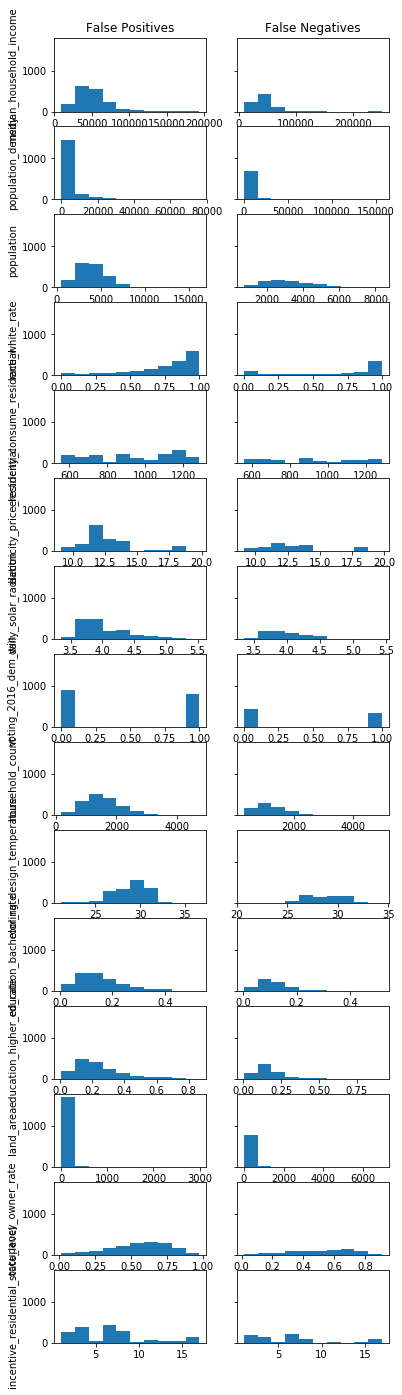

In [130]:
variables = ['median_household_income','population_density', 
             'population','race_white_rate','electricity_consume_residential',
             'electricity_price_residential','daily_solar_radiation', 
             'voting_2016_dem_win', 'household_count',
             'cooling_design_temperature','education_bachelor_rate','education_higher_ed_rate',
            'land_area','occupancy_owner_rate', 'incentive_residential_state_level']

fig, ax = plt.subplots(ncols = 2, nrows = len(variables), sharey=True,figsize = [6, 24])
for ind, var in enumerate(variables):
    ax[ind][0].hist(df_fp[var])
    ax[ind][1].hist(df_fn[var])
    ax[ind][0].set_ylabel(var)


ax[0][0].set_title("False Positives")
ax[0][1].set_title('False Negatives')

In [67]:
# Train and score the classifier
# log_reg = linear_model.LogisticRegression()
# log_reg.fit(X_train_bins, y_train_bins)
# print(log_reg.score(X_test_bins, y_test_bins))
# preds = log_reg.predict(X_test_bins)
# score: 0.731534195933



# rf = ensemble.RandomForestClassifier()
# rf.fit(X_train_bins, y_train_bins)
# print(rf.score(X_test_bins, y_test_bins))
# score: 0.789426987061

# svc = svm.SVC()
# svc.fit(X_train_bins, y_train_bins)
# print(svc.score(X_test_bins, y_test_bins))
# score: 0.728946395564

X_train['bins'] = y_train_bins
X_test['bins'] = y_test_bins
key = 'bins'

models = {'lin_reg':linear_model.LinearRegression(), 'clf':ensemble.GradientBoostingRegressor()}#**params)}

model_results = {}
model_results[key]={}
for slce in list(set(X_train[key])):
        binned_var_omit = [col for col in X_train.columns if '_bin' in col]

        X_train_tmp = X_train[X_train[key]==slce]
        y_train_tmp = X_train_tmp[target]
        X_train_tmp = X_train_tmp.loc[:, ~(X_train_tmp.columns).isin([target]+['bins']+binned_var_omit)]
                                      
        X_test_tmp = X_test[X_test[key]==slce]
        y_test_tmp = X_test_tmp[target]
        X_test_tmp = X_test_tmp.loc[:, ~(X_test_tmp.columns).isin([target]+['bins']+binned_var_omit)]
        if len(X_train_tmp)>0:
            model_results[key][slce] = {}
            for model_key in models.keys():
                try:
                    model = models[model_key].fit(X_train_tmp, y_train_tmp)
                    model_results[key][slce][model_key]= {'model':model, 'score':model.score(X_test_tmp, y_test_tmp), 'cv':cross_val_score(model,X_train_tmp, y_train_tmp), 
                                      'y_pred': model.predict(X_test_tmp), 'y_test':y_test_tmp }
                    print(key,slce,model_key, model_results[key][slce][model_key]['cv'])
                except:
                    continue
    

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


bins 0 lin_reg [ 1.  1.  1.]


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


bins 0 clf [ 1.  1.  1.]


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


bins 1 lin_reg [ 1.  1.  1.]


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


bins 1 clf [ 1.  1.  1.]
bins 2 

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


lin_reg [ 1.  1.  1.]


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


bins 2 clf [ 1.  1.  1.]


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


bins 3 lin_reg [ 0.02106009  0.02224904  0.01168114]


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


bins 3 clf [ 0.03025955  0.03569591  0.02163066]


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


bins 4 lin_reg [ 0.1593981   0.18243601  0.171757  ]


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


bins 4 clf [ 0.1914463   0.20911643  0.19469943]


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


bins 5 lin_reg [ 0.46511655  0.40940333  0.47148954]


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


bins 5 clf [ 0.59023499  0.56874652  0.6125097 ]
